## Air Quality in Vanderbijlpark Prediction (LINEAR REGRESSION)

In [1]:
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

In [2]:

def wrangle(filename):
    #We read the filename into a dataframe and passing the ';' as a delimiter
    df = pd.read_csv(filename,delimiter=';')
    # We convert our timestamp column of object datatype to a timestamp datatype
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    # We set the index of the dataframe to be the timestamp 
    df.set_index('timestamp',inplace=True)
    #We  convert the timestamp to the 'Africa/Johannesburg' timezone since the dataset is gotten from Vanderbijlpark
    df.index = df.index.tz_convert('Africa/Johannesburg')
    #Sort Our data Frame by index
    df = df.sort_index()
    #We mask our DataFrame to return value that contains the P2 value type
    mask = df['value_type'] == 'P2'
    df  = df[mask]
    ## we identify column with low and high cardinality and drop them
    low_cardinality_list = [column for column in df.columns if df[column].nunique() < 2 ]
    df.drop(low_cardinality_list,axis=1,inplace = True)
    # We resample the dataframe to return a series with the mean of the P2 value for every Hour
    y =  df['value'].resample('1H').mean().fillna(method ='ffill')
    y.name = 'P2'
    return y
    

### 1. IMPORT

In [3]:
#Returns all files that matches the pattern as specified in the glob function argument
files = glob('data/*_2021_sensor_data_archive.csv')

In [4]:
#A list comprehension for that perform the wrangle function for each file in the list created by glob funtion
list_of_df = [wrangle(file) for file in files]
# We concatenate the list of dataframes into one dataframe using the pd.concat method and set index to the timestamp
y = pd.concat(list_of_df).sort_index()

### 2. EXPLORE

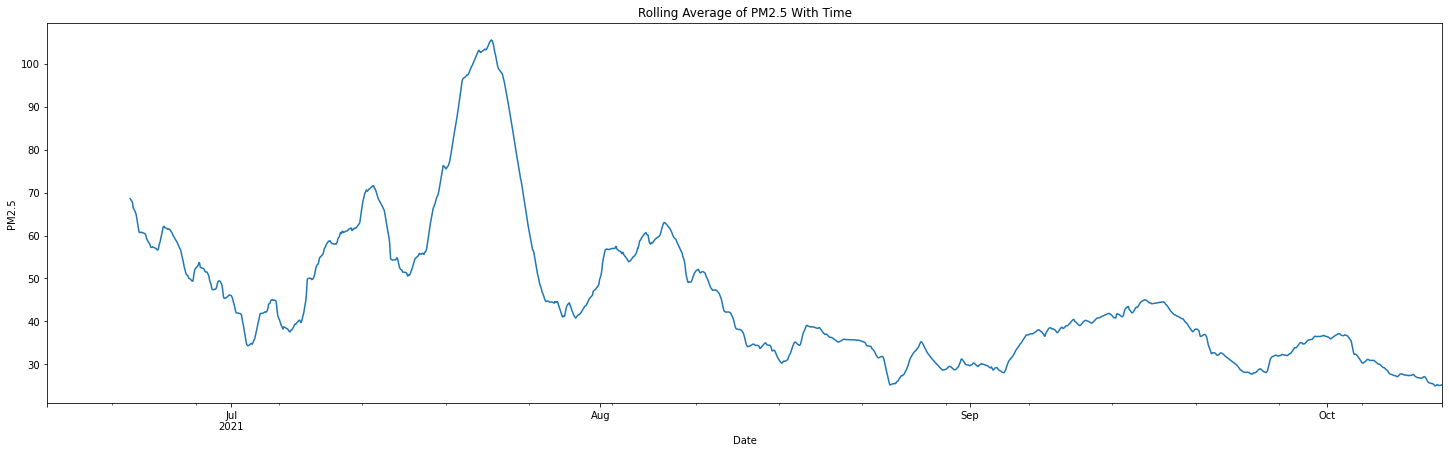

In [5]:
#We plot the weekly rolling average to get an idea of how the data could change in future
fig,ax = plt.subplots(figsize=(25,7))
y.rolling(168).mean().plot(ax=ax);
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.title('Rolling Average of PM2.5 With Time');


In [6]:
#Since we have no feature and only a target value, we could create a lag feature from the target.
#First we convert our series to a DataFrame
df = y.to_frame()
df.head()

,P2
timestamp,
2021-06-15 13:00:00+02:00,33.639524
2021-06-15 14:00:00+02:00,32.994074
2021-06-15 15:00:00+02:00,38.932037
2021-06-15 16:00:00+02:00,44.727455
2021-06-15 17:00:00+02:00,65.747170


In [7]:
# Next we create a new feature called 'P2.Lag1' which is the value from previous row
df['P2.Lag1'] = df['P2'].shift(1)
df.dropna(inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2812 entries, 2021-06-15 14:00:00+02:00 to 2021-10-10 17:00:00+02:00
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   P2       2812 non-null   float64
 1   P2.Lag1  2812 non-null   float64
dtypes: float64(2)
memory usage: 65.9 KB


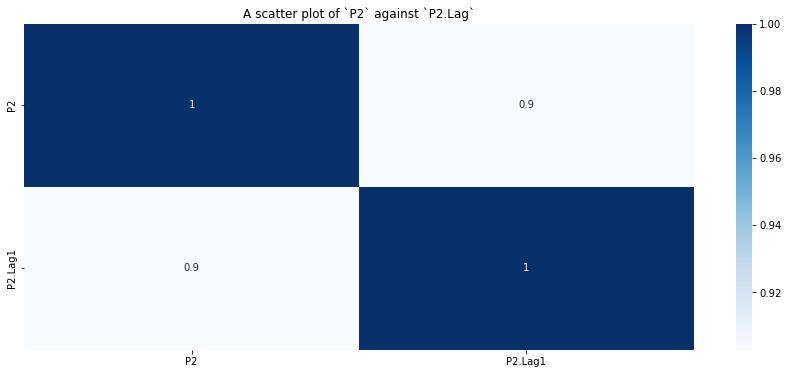

In [9]:
#Next we create a heatmap between the feature and target
fig,ax = plt.subplots(figsize=(15,6))
sns.heatmap(df.corr(),annot=True,ax=ax,cmap='Blues')
#Title
plt.title('A scatter plot of `P2` against `P2.Lag`');

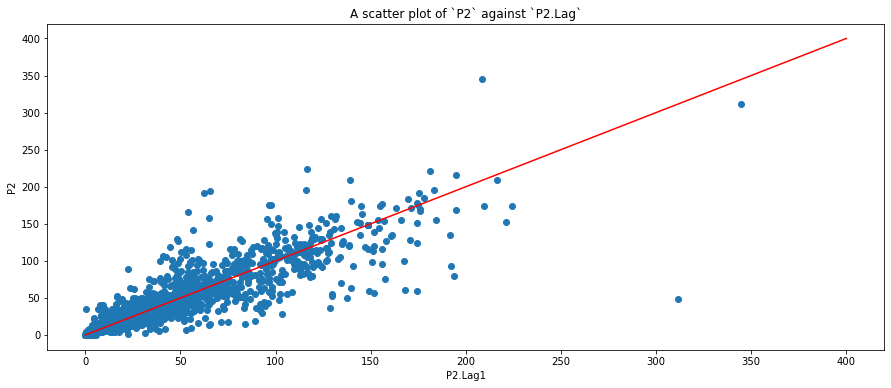

In [10]:
fig,ax = plt.subplots(figsize=(15,6))
#We plot a scatter plot of 'P2' against 'P2.Lag'
plt.scatter(data = df,x='P2.Lag1',y='P2')
#We plot a straight line from the origin to check our distributed our scatter plot.
plt.plot([0,400],[0,400],linestyle='solid',color='red')
#xlabel
plt.xlabel('P2.Lag1')
plt.ylabel('P2')
plt.title('A scatter plot of `P2` against `P2.Lag`');

### 3. SPLIT

In [11]:
# Split DataFrame in X(Feature) and y(Target).
target = 'P2'
# Feature column
X = df.drop(target,axis=1)
y = df[target]

In [12]:
#We split into Train and Test set. Since it is a Time Based Data, We ensure no future data is present in the test set.
# We Split in the Ratio 80:20
cut_off = int(len(X)*0.8)
X_train = X[:cut_off]
X_test = X[cut_off:]
y_train = y[:cut_off]
y_test = y[cut_off:]

### 4. BUILD MODEL

#### A. BASELINE

In [13]:
# We create a baseline model which would be used to test how well our test data those.
# The baseline will be the mean absolute error of y_train against that of y_mean
y_mean = y_train.mean()
y_pred_baseline = [y_mean]*len(y_train)
y_baseline_df = pd.DataFrame({'y_train' : y_train,'y_baseline':y_pred_baseline})
mae = mean_absolute_error(y_train,y_pred_baseline)
print(f' The mean of the y_train is {y_mean}')
print(f' The mean absolute error of the baseline model is {mae}')

 The mean of the y_train is 49.35788111267553
 The mean absolute error of the baseline model is 28.497568594535963


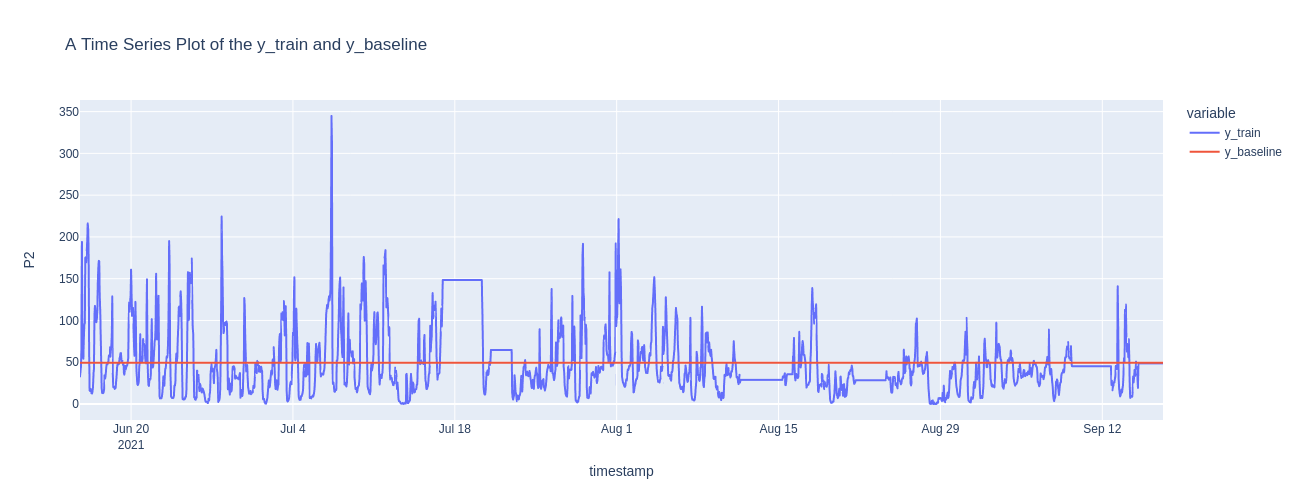

In [14]:
fig = px.line(y_baseline_df,labels={'value':'P2'},title='A Time Series Plot of the y_train and y_baseline',width=1300)
fig.show('png');

### B. LINEAR REGRESSION MODEL

In [15]:
#We instantiate the model and fit to the training data
lr_model = LinearRegression() 
lr_model.fit(X_train,y_train)

LinearRegression()

In [16]:
#Next we predict the X_train and calculate the mean absolute error
y_train_pred = lr_model.predict(X_train)
lr_mae = mean_absolute_error(y_train,y_train_pred)
print(f' The mean absolute error of the Linear Regression model with the train test is {lr_mae}')

 The mean absolute error of the Linear Regression model with the train test is 9.310029242648653


In [17]:
# Next we make prediction of X_test and compare with y_test
y_test_pred = lr_model.predict(X_test)
lr_test_mae = mean_absolute_error(y_test,y_test_pred)
print(f' The mean absolute error of the Linear Regression model with the test set is {lr_test_mae}')

 The mean absolute error of the Linear Regression model with the test set is 5.093620077713406


### 5. COMMUNICATE RESULT

In [18]:
# We extract the coefficent and intercept
intercept = round(lr_model.intercept_,2)
coef = round(lr_model.coef_[0],2)
print(f' The intercept of the linear regression model is {intercept} and the coefficient is {coef}, therefore equation is:')
print(f'\n\n\t\t\t P2 = (P2.Lag1) x {coef} +  {intercept}')

 The intercept of the linear regression model is 5.02 and the coefficient is 0.9, therefore equation is:


			 P2 = (P2.Lag1) x 0.9 +  5.02


In [19]:
y_pred_df = pd.DataFrame({
                'y_test':y_test,
                'y_prediction':y_test_pred
})
y_pred_df.head()

,y_test,y_prediction
timestamp,,
2021-09-17 07:00:00+02:00,48.680000,48.754933
2021-09-17 08:00:00+02:00,23.063846,48.754933
2021-09-17 09:00:00+02:00,29.938868,25.743364
2021-09-17 10:00:00+02:00,23.692000,31.919351
2021-09-17 11:00:00+02:00,12.362353,26.307649


In [20]:
y_pred_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 563 entries, 2021-09-17 07:00:00+02:00 to 2021-10-10 17:00:00+02:00
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   y_test        563 non-null    float64
 1   y_prediction  563 non-null    float64
dtypes: float64(2)
memory usage: 13.2 KB


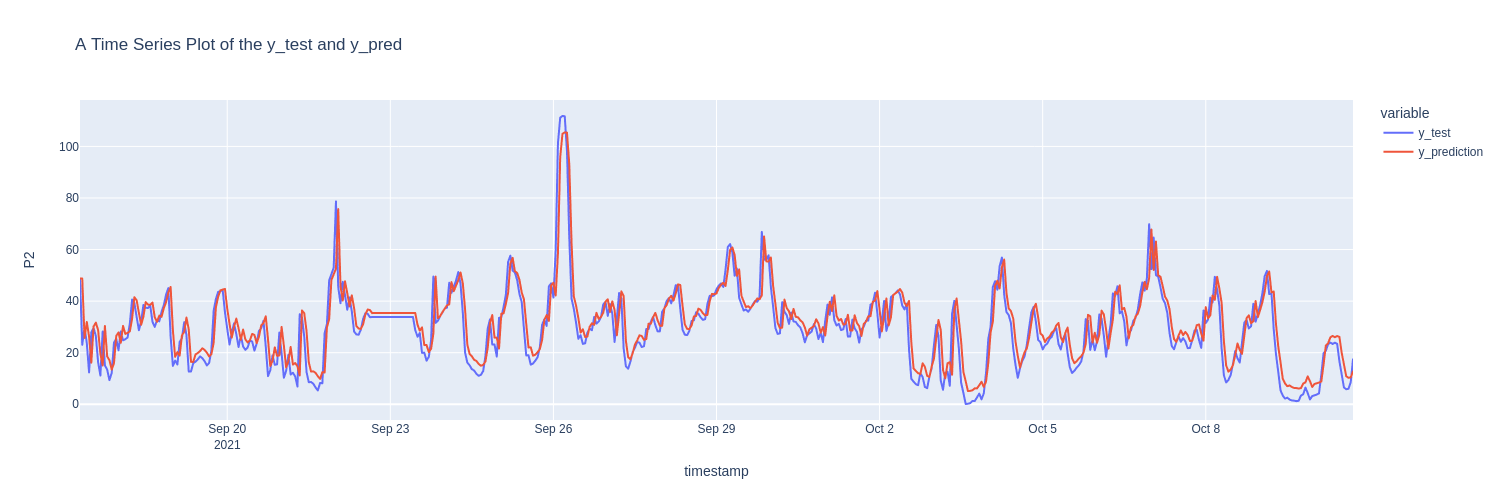

In [21]:
fig = px.line(y_pred_df,labels={'value':'P2'},title='A Time Series Plot of the y_test and y_pred',width=1500)
fig.show('png');